In [1]:
%matplotlib notebook

In [2]:
import h5py as h5
from stemutils.io import *
import hyperspy.api as hs

In [3]:
root = Path('/dls/i08/data/2022/mg32587-1/processing/')

In [4]:
root.walk()

[Path('/dls/i08/data/2022/mg32587-1/processing/68025c.nxs'),
 Path('/dls/i08/data/2022/mg32587-1/processing/68049c.nxs'),
 Path('/dls/i08/data/2022/mg32587-1/processing/README.reprocessing'),
 Path('/dls/i08/data/2022/mg32587-1/processing/68028c.nxs')]

In [5]:
fp = root.walk('049c.nxs')[0]

In [62]:
with h5.File(fp) as f:
    #print(f['entry']['scan_shape'])
    fdata = f['entry1']['Counter1']['data'][()]
    pe = f['entry1']['Counter1']['photon_energy'][()]
    sample_x = f['entry1']['Counter1']['sample_x'][()]
    sample_y = f['entry1']['Counter1']['sample_y'][()]
    print(f['entry1']['Counter1'].keys())

<KeysViewHDF5 ['count_time', 'data', 'photon_energy', 'sample_x', 'sample_y', 'scan_type']>


/home/dto55534/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [63]:
cropx = 5
cropy = 5

In [64]:
fdata = fdata[:,cropx:, cropy:]

In [65]:
step_x = np.mean(np.diff(sample_x))
step_y = np.mean(np.diff(sample_y))

<IPython.core.display.Javascript object>


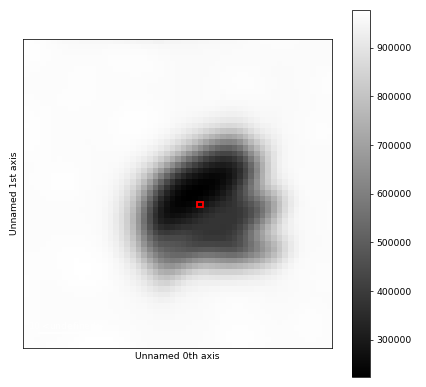

<IPython.core.display.Javascript object>


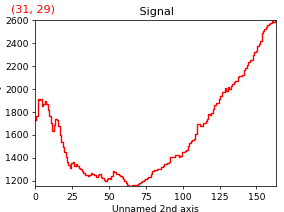

In [121]:
hs.signals.Signal1D(fdata.T).plot()

In [66]:
fdata.shape

(164, 55, 55)

In [67]:
sample_y.shape

(60,)

In [68]:
fsig = hs.signals.Signal2D(fdata)

In [69]:
fdata.shape

(164, 55, 55)

In [70]:
th_data = []
thresh_val =0.7
for d in fdata:
    th_data.append(np.where(d< d.max()*thresh_val,1,0))

In [71]:
th_data = np.asarray(th_data)

In [72]:
th_data = th_data

In [73]:
tsig = hs.signals.Signal2D(np.asarray(th_data))

In [74]:
tsig

<Signal2D, title: , dimensions: (164|55, 55)>

<IPython.core.display.Javascript object>


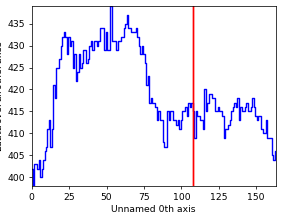

<IPython.core.display.Javascript object>


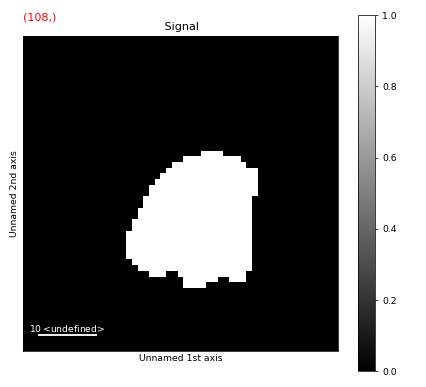

In [75]:
tsig.plot()

<IPython.core.display.Javascript object>


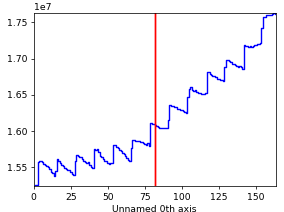

<IPython.core.display.Javascript object>


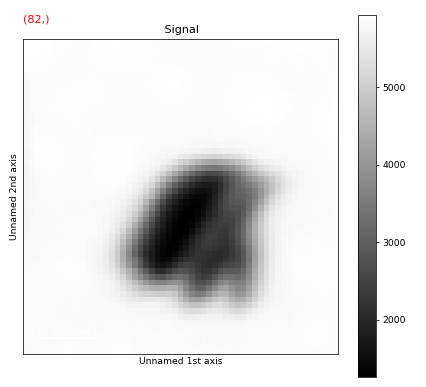

In [76]:
fsig.plot()

In [77]:
from skimage import filters, feature

In [78]:
tdata = th_data[0]

In [79]:
roberts = filters.roberts(tdata.astype('float'))

In [80]:
bin_rob = np.where(roberts != 0, 1, 0)

In [81]:
import matplotlib.pyplot as plt

In [82]:
from scipy.ndimage.measurements import center_of_mass as com

<IPython.core.display.Javascript object>


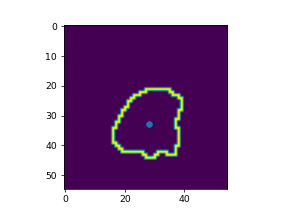

In [83]:
plt.figure()
plt.imshow(bin_rob)
com_bin_rob = com(bin_rob)
plt.scatter(com_bin_rob[1], com_bin_rob[0])

In [84]:
all_rob = np.asarray([np.where(filters.roberts(tdata.astype('float')) != 0, 1,0) for tdata in th_data])
coms = np.asarray([com(rob) for rob in all_rob])

<IPython.core.display.Javascript object>


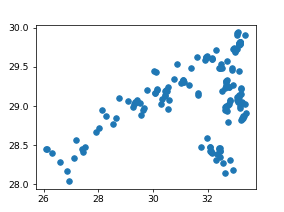

In [85]:
plt.figure()
plt.scatter(coms[:,0], coms[:,1])

In [86]:
pfit = np.polyfit(coms[:,0], coms[:,1], 5)

In [146]:
px = np.linspace(np.min(coms[:,0]),np.max(coms[:,0]),1000)
py = np.polyval(pfit, px)

In [147]:
pvals = np.concatenate((px[:,None], py[:,None]), axis = 1)

In [148]:
pvals_comp = px +1j*py
coms_comp = coms[:,0] + 1j*coms[:,1]

<IPython.core.display.Javascript object>


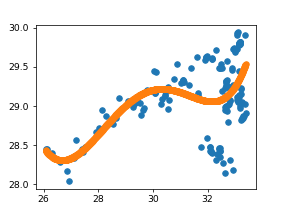

In [149]:
plt.figure()
plt.scatter(coms[:,0], coms[:,1])
plt.scatter(px,py)

In [586]:
reg_coms = []
for com_comp in coms_comp:
    reg_com = pvals_comp[np.argmin(np.abs(pvals_comp - com_comp))]
    reg_coms.append((reg_com.real, reg_com.imag))
reg_coms = np.asarray((reg_coms))

In [91]:
all_rob_sig = hs.signals.Signal2D(all_rob)

<IPython.core.display.Javascript object>


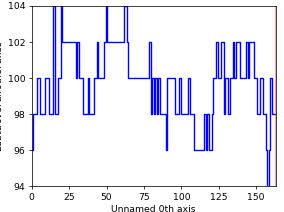

<IPython.core.display.Javascript object>


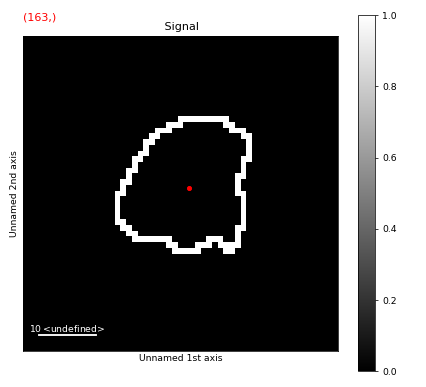

In [92]:
m = hs.plot.markers.point(x = coms[:,1], y = coms[:,0], color='red')
all_rob_sig.add_marker(m)

In [93]:
ffsig = hs.signals.Signal2D(fdata)

<IPython.core.display.Javascript object>


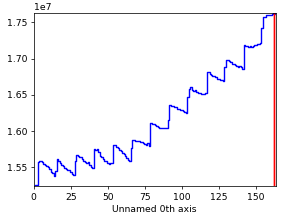

<IPython.core.display.Javascript object>


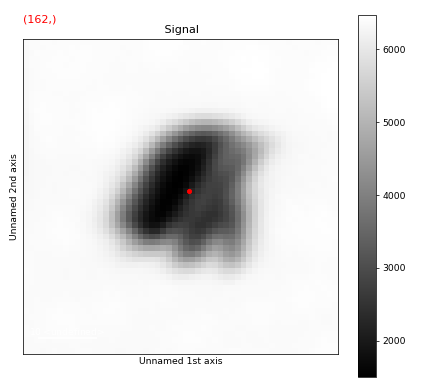

In [94]:
m3 = hs.plot.markers.point(x = coms[:,1], y = coms[:,0], color='red')
ffsig.add_marker(m3)

In [96]:
from scipy.ndimage import shift

In [97]:
reg_shift = coms - coms[0]

In [98]:
reg_data = []
for ind, shift_val in enumerate(reg_shift):
    reg_data.append(shift(fdata[ind], -shift_val))

In [99]:
reg_sig = hs.signals.Signal2D(reg_data)

<IPython.core.display.Javascript object>


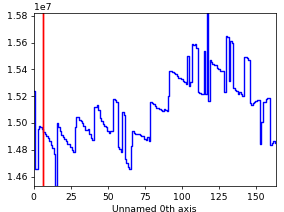

<IPython.core.display.Javascript object>


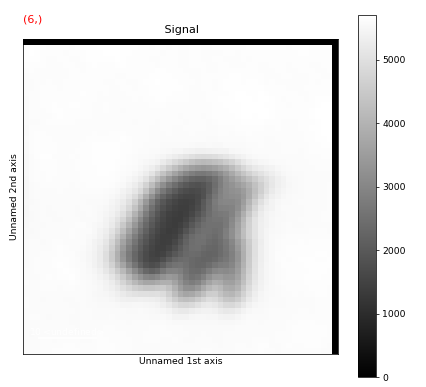

In [100]:
reg_sig.plot()

In [104]:
final_reg_sig = hs.signals.Signal2D(reg_sig.data[:,10:-5, 10:-10])

In [105]:
final_reg_data = final_reg_sig.data

<IPython.core.display.Javascript object>


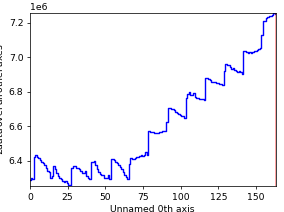

<IPython.core.display.Javascript object>


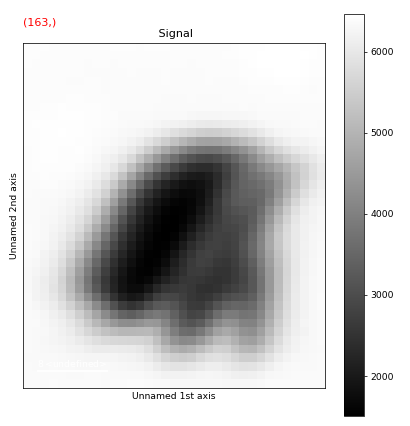

In [106]:
final_reg_sig.plot()

In [107]:
final_reg_data.shape

(164, 40, 35)

In [108]:
sigT_data = final_reg_data.transpose((1,2,0))

In [109]:
sigT_data.shape

(40, 35, 164)

In [110]:
dict0 = {'axis':pe, 'units': 'eV'}
dict1 = {'axis':np.arange(0, sigT_data.shape[0] * step_x, step_x), 'units': 'um'}
dict2 = {'axis':np.arange(0, sigT_data.shape[1]*step_y, step_y), 'units': 'um'}

In [111]:
dict2['axis'].shape

(35,)

In [112]:
dict1['axis'].shape

(40,)

In [113]:
sigT = hs.signals.Signal1D(sigT_data,axes = [dict2, dict1, dict0])

In [114]:
sigT.axes_manager

Navigation axis name,size,index,offset,scale,units
,40,0,non-uniform axis,non-uniform axis,um
,35,0,non-uniform axis,non-uniform axis,um
Signal axis name,size,,offset,scale,units
,164,,non-uniform axis,non-uniform axis,eV


<IPython.core.display.Javascript object>


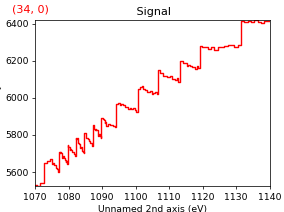

Exception occurred in traits notification handler for object: Unnamed 0th axis, trait: index, old value: 34, new value: 35
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

Exception occurred in traits notification handler.
Please check the log file for details.


TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 39, but a value of 35 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 0th axis, trait: index, old value: 35, new value: 36
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 39, but a value of 36 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 0th axis, trait: index, old value: 36, new value: 37
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 39, but a value of 37 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 0th axis, trait: index, old value: 37, new value: 38
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 39, but a value of 38 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 0, new value: 1
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax_l

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 1 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 1, new value: 4
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax_l

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 4 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 4, new value: 8
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax_l

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 8 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 8, new value: 10
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax_

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 10 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 10, new value: 13
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 13 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 13, new value: 14
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 14 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 14, new value: 15
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 15 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 15, new value: 16
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 16 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 16, new value: 17
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 17 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 17, new value: 18
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 18 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 18, new value: 19
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 19 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 19, new value: 20
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 20 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 20, new value: 21
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 21 <class 'int'> was specified.

Exception occurred in traits notification handler for object: Unnamed 1st axis, trait: index, old value: 21, new value: 22
Traceback (most recent call last):
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 578, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/traits/trait_notifiers.py", line 540, in dispatch
    handler(*args)
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/axes.py", line 1854, in _on_index_changed
    self.events.indices_changed.trigger(obj=self)
  File "<string>", line 4, in trigger
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/events.py", line 422, in trigger
    function(**{kw: kwargs.get(kw, None) for kw in kwsl})
  File "/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/signal1d.py", line 233, in update
    update_lines(self.ax, self.ax

TraitError: The 'index' trait of a DataAxis instance must be 0 <= a number <= 34, but a value of 22 <class 'int'> was specified.

In [115]:
sigT.plot()

In [116]:
sigT2 = hs.signals.Signal1D(sigT_data)

<IPython.core.display.Javascript object>


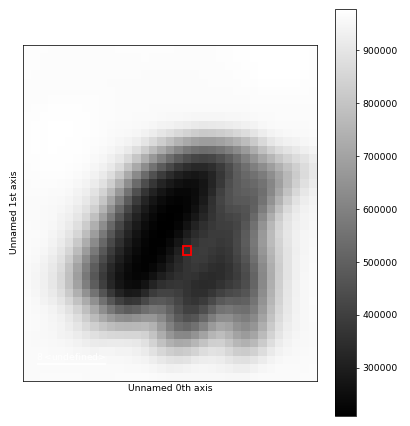

<IPython.core.display.Javascript object>


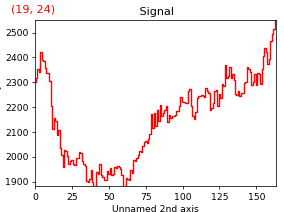

In [117]:
sigT2.plot()

In [122]:
sum_ints = np.sum(final_reg_data, axis = (0))

In [123]:
sum_ints.shape

(40, 35)

In [130]:
bkg_thresh = 0.97

In [131]:
bkg_mask = np.where(sum_ints>np.max(sum_ints)*bkg_thresh,1,0)
mask_loc = np.where(sum_ints>np.max(sum_ints)*bkg_thresh+0.2)

/home/dto55534/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


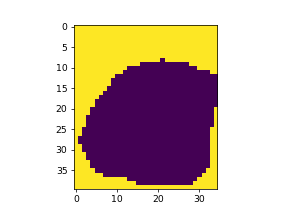

In [132]:
plt.figure()
plt.imshow(bkg_mask)

In [133]:
mask_coords = np.asarray(mask_loc).T

In [134]:
all_bkg = []
for mc in mask_coords:
    all_bkg.append(sigT.data[mc[0], mc[1],:])
all_bkg = np.asarray(all_bkg)

In [135]:
mean_bkg_profile = np.mean(all_bkg, axis = 0)

<IPython.core.display.Javascript object>


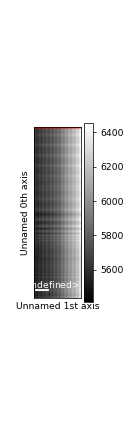

<IPython.core.display.Javascript object>


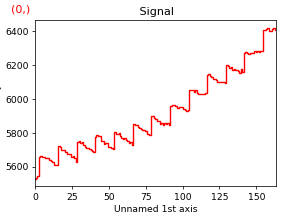

In [136]:
hs.signals.Signal1D(all_bkg).plot()

<IPython.core.display.Javascript object>


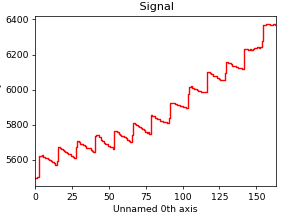

In [137]:
hs.signals.Signal1D(mean_bkg_profile).plot()

In [138]:
abs_sig = hs.signals.Signal1D(1-(sigT.data / mean_bkg_profile[None,None,:]))

<IPython.core.display.Javascript object>


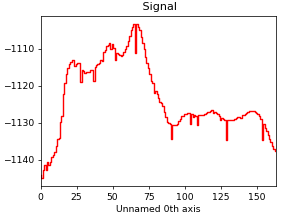

In [139]:
hs.signals.Signal1D(1-(sigT.data / mean_bkg_profile[None,None,:]).sum(axis = (0,1))).plot()

<IPython.core.display.Javascript object>


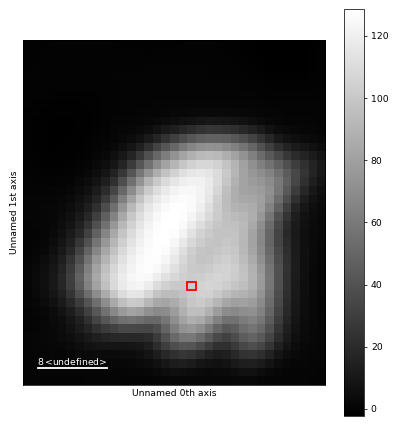

<IPython.core.display.Javascript object>


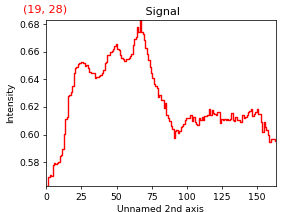

In [140]:
abs_sig.plot()

In [141]:
abs_sig_en = hs.signals.Signal1D(abs_sig.data,axes = [dict2, dict1, dict0])

<IPython.core.display.Javascript object>


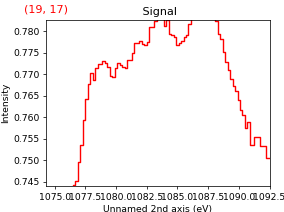

In [142]:
abs_sig_en.plot()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=7
  centre=None


/home/dto55534/.local/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


<IPython.core.display.Javascript object>


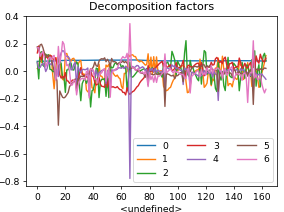

<IPython.core.display.Javascript object>


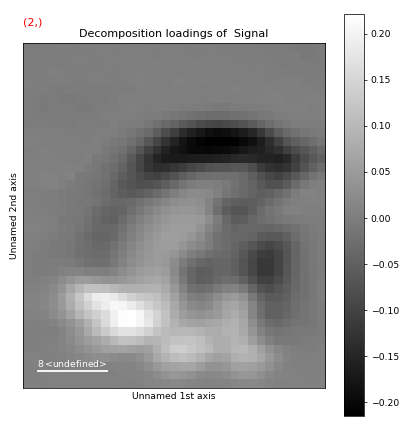

<IPython.core.display.Javascript object>


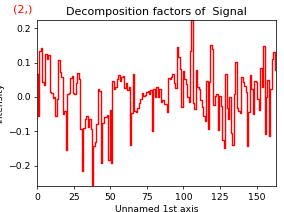

In [145]:
import pyxem as pxm

t_abs = pxm.signals.ElectronDiffraction1D(np.abs(abs_sig.data))

t_abs.decomposition(algorithm = 'SVD', output_dimension=7)

t_abs.plot_decomposition_factors()

t_abs.plot_decomposition_results()